In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import string

from nltk.tokenize import TweetTokenizer

from models.MeTooDataset import MeTooDataset

In [2]:
experiment_name = '8A'

In [3]:
training_dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data',
    mode='bag_of_words',
    task='metoo_training'
)

In [4]:
labels = ['Against', 'Neutral', 'Favor']

In [5]:
tokenizer = TweetTokenizer()

# Sentence Length

In [6]:
df = pd.DataFrame(
    {
        'sent_len': training_dataset.X.apply(
            lambda x: len(tokenizer.tokenize(x))
        ),
        'group': training_dataset.y
    }
)

In [7]:
groups = [df.groupby('group').get_group(group)['sent_len'].values for group in set(training_dataset.y)]

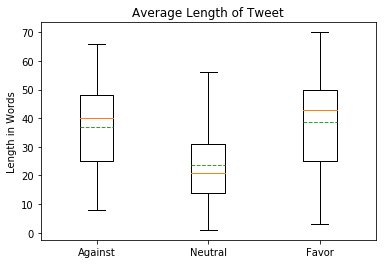

In [8]:
plt.title('Average Length of Tweet')
plt.ylabel('Length in Words')

plt.boxplot(groups, showfliers=False, showmeans=True, meanline=True, labels=labels)

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_tweet_length.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Word Length

In [9]:
df = pd.DataFrame(
    {
        'word_len': training_dataset.X.apply(
            lambda x: np.array(
                [
                    len(w)
                    for w in x.split()
                ],
                dtype=np.int16
            )
        ),
        'group': training_dataset.y
    }
)

In [10]:
groups = [
    np.concatenate(
        df.groupby('group').get_group(group)['word_len'].values
    )
    for group in set(training_dataset.y)
]

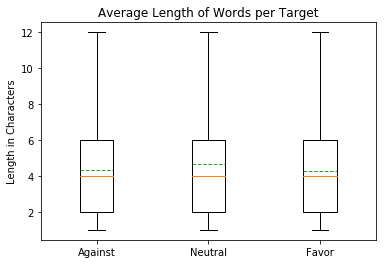

In [11]:
plt.title('Average Length of Words per Target')
plt.ylabel('Length in Characters')
plt.boxplot(groups, showfliers=False, showmeans=True, meanline=True, labels=labels)

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_word_length.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Amount of Punctuation

In [12]:
df = pd.DataFrame(
    {
        'amount_of_punctuation': training_dataset.X.apply(
            lambda x: len([w for w in x if w in string.punctuation])/len(x)*100.
        ),
        'group': training_dataset.y
    }
)

In [13]:
groups = [
    df.groupby('group').get_group(group)['amount_of_punctuation'].values
    for group in set(training_dataset.y)
]

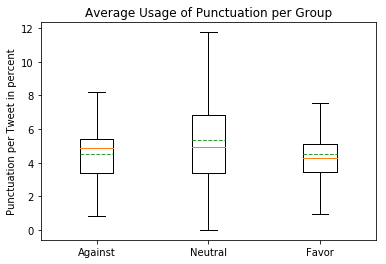

In [14]:
plt.title('Average Usage of Punctuation per Group')
plt.ylabel('Punctuation per Tweet in percent')
plt.boxplot(groups, showfliers=False, showmeans=True, meanline=True, labels=labels)

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_punctuation.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Size of Vocabulary

In [15]:
df = pd.DataFrame(
    {
        'text': training_dataset.X.apply(str.split),
        'group': training_dataset.y
    }
)

In [16]:
groups = [
    len(set(np.concatenate(df.groupby('group').get_group(group)['text'].values)))
    for group in set(training_dataset.y)
]

In [17]:
df_vocab = pd.DataFrame.from_dict(
    {
        'Training Dataset': {
            'Against': groups[0],
            'Neutral': groups[1],
            'Favor': groups[2]
        }
    }
).transpose()

df_vocab = df_vocab[['Against', 'Neutral', 'Favor']]

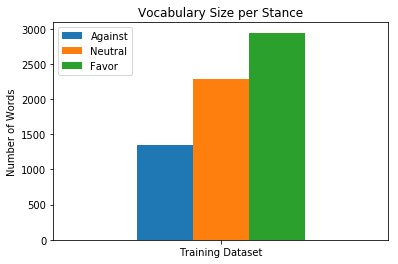

In [18]:
df_vocab.plot(kind='bar', title='Vocabulary Size per Stance', rot=0)

plt.ylabel('Number of Words')
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_vocabulary.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Use of Personal Pronouns

Source: https://uwm.edu/lgbtrc/support/gender-pronouns/

In [19]:
pronouns = {
    'male': {
        'he', 'him', 'his', 'himself'
    },
    
    'female': {
        'she', 'her', 'hers', 'herself'
    },
    
    'non-binary': {
        'zie', 'sie', 'ey', 've', 'tey', 'e',
        'zim', 'sie', 'em', 'ver', 'ter', 'em',
        'zir', 'hir', 'eir', 'vis', 'tem', 'eir',
        'zis', 'hirs', 'eirs', 'vers', 'ters', 'eirs',
        'zieself', 'hirself', 'eirself', 'verself', 'terself', 'emself'
    }
}

In [20]:
df = pd.DataFrame(
    {
        'text': training_dataset.X.apply(tokenizer.tokenize),
        'group': training_dataset.y
    }
)

In [21]:
grouped_by_group = [
    np.concatenate(
        df.groupby('group').get_group(group)['text'].values
    )
    
    for group in set(training_dataset.y)
]

In [22]:
grouped_by_group

[array(['rt', ':', '@climateaudit', ..., 'open', 'discussion', '.'],
       dtype='<U22'),
 array(['rt', ':', '"', ..., '@twitter', '#boycottverified', '#hsbs'],
       dtype='<U29'),
 array(['trump', 'is', 'not', ..., "can't", 'die', '.'], dtype='<U36')]

In [23]:
text_counters = [
    collections.Counter(group)
    for group in grouped_by_group
]

In [24]:
groups = [
    [
        sum(
            [
                counter[pronoun]
                for pronoun in pronouns[key]
            ]
        ) / sum([value for word, value in counter.items() if not word in string.punctuation]) * 100.
        for counter in text_counters
    ]
    for key in pronouns.keys()
]

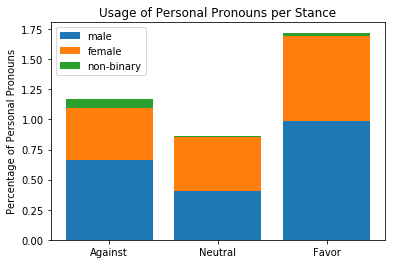

In [25]:
p1 = plt.bar(np.arange(len(groups)), groups[0])
p2 = plt.bar(np.arange(len(groups)), groups[1], bottom=groups[0])
p3 = plt.bar(np.arange(len(groups)), groups[2], bottom=[groups[0][idx] + groups[1][idx] for idx in range(len(groups[0]))])

plt.title('Usage of Personal Pronouns per Stance')
plt.ylabel('Percentage of Personal Pronouns')
plt.xticks(np.arange(len(labels)), labels)
plt.legend((p1[0], p2[0], p3[0]), ('male', 'female', 'non-binary'))

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_pronouns.eps', 'wb') as f:
    plt.savefig(f, format='eps')